<a href="https://colab.research.google.com/github/priyalpote/timeSeriesAnalysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox


#pip install pmdarima
import sys
!{sys.executable} -m pip install pmdarima

from pmdarima import auto_arima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.8 MB/s eta 0:00:00


# Load and prepare Data

From Airpessanger dataset

In [4]:
pd.read_csv('https://raw.githubusercontent.com/priyalpote/timeSeriesAnalysis/main/Data/data/AirPassengers.csv')

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


# Prepare Data

In [5]:
df =  pd.read_csv('https://raw.githubusercontent.com/priyalpote/timeSeriesAnalysis/main/Data/data/AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Describe the Data

In [8]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


Plot data

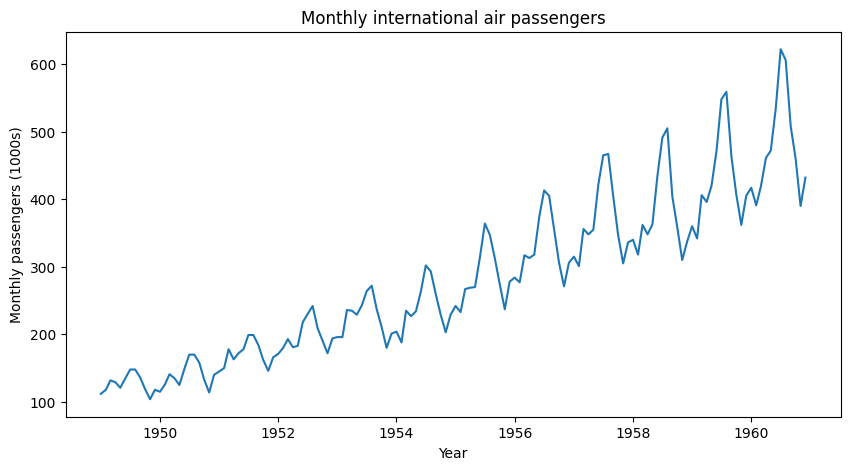

In [7]:

plt.figure(figsize=(10, 5))
plt.plot(df)
plt.xlabel('Year')
plt.ylabel('Monthly passengers (1000s)')
plt.title('Monthly international air passengers')
plt.show()


# Decompose time series
period = months

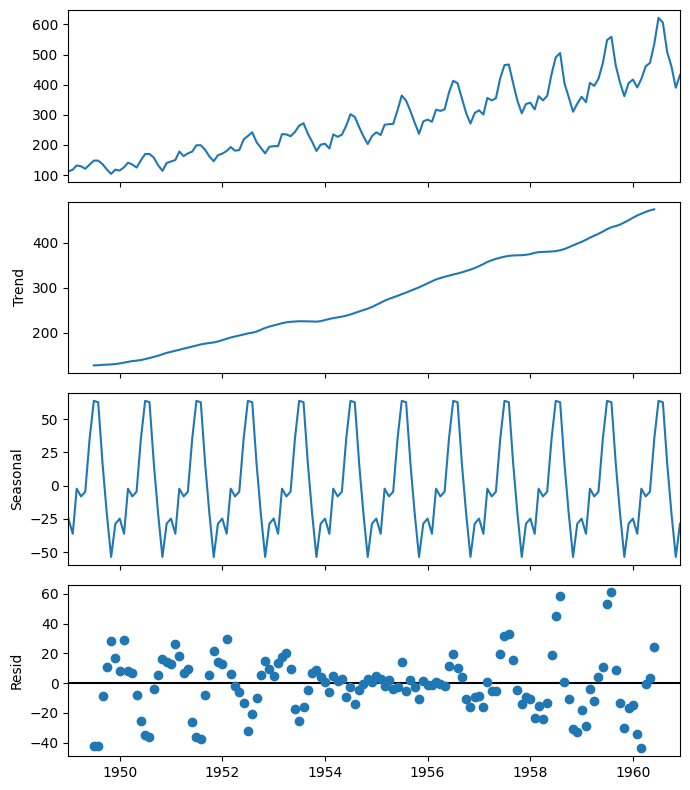

In [9]:
#set the figure size
plt.rcParams['figure.figsize']=[7,8]

#plot the decomposition components
sd= seasonal_decompose(df, period=12).plot()

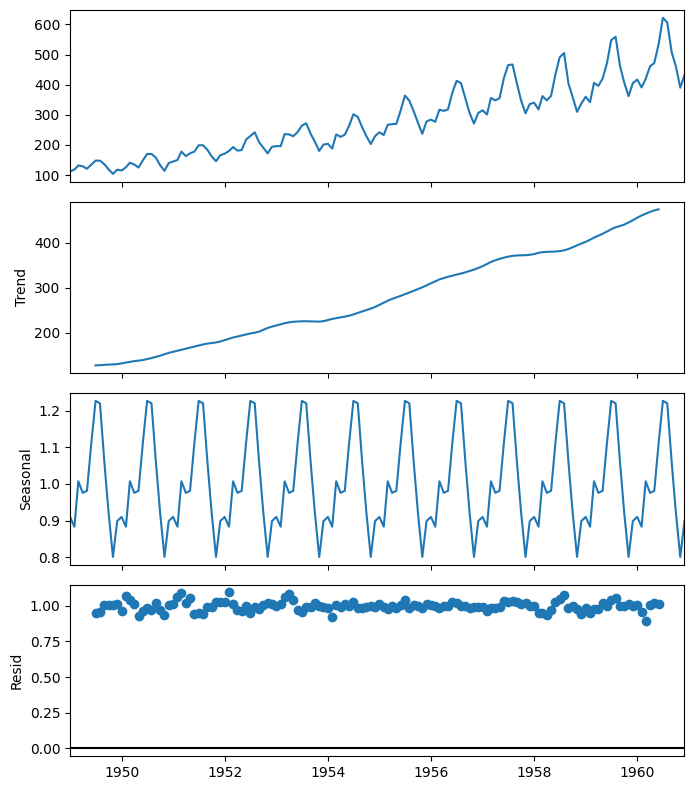

In [10]:
sd =  seasonal_decompose(df,model='multiplicative').plot()

# ARIMA
need to install arima

In [11]:
#pip install pmdarima
import sys
!{sys.executable} -m pip install pmdarima

ERROR: Operation cancelled by user


# Split Data


In [12]:

trn = df[df.index < '1958-01-01']
tst = df[df.index >= '1958-01-01']


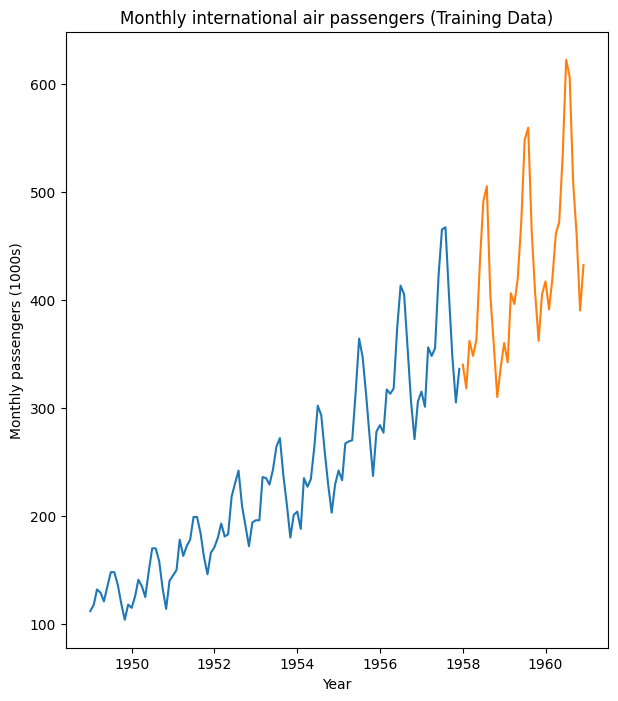

In [13]:

fig, ax = plt.subplots()
plt.plot(trn)
plt.plot(tst)
plt.xlabel('Year')
plt.ylabel('Monthly passengers (1000s)')
plt.title('Monthly international air passengers (Training Data)')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))


# Prepare Model
Test stationary

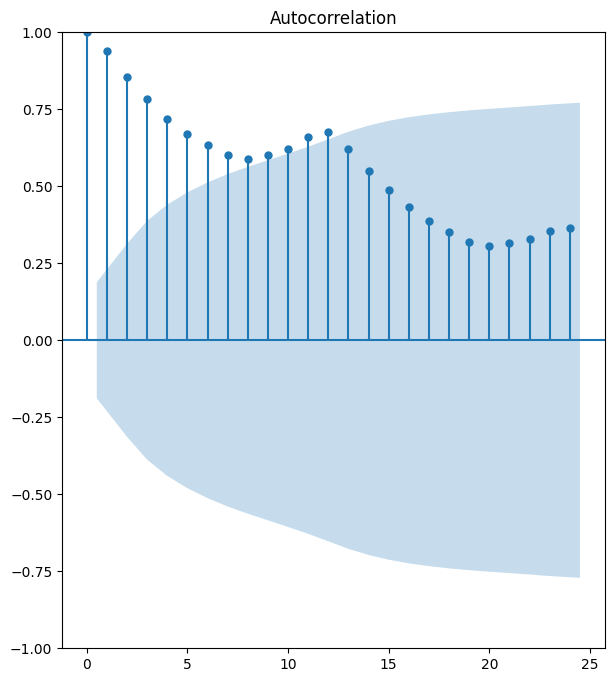

In [14]:
trn.acf= plot_acf(trn, lags=24)

# Linear Model

In [15]:
lr = sm.OLS(endog=trn['#Passengers'], exog=sm.add_constant(np.arange(1,1+trn.shape[0]))).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           6.40e-43
Time:                        01:31:22   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

In [16]:
y_hat = lr.fittedvalues

In [17]:
y_ci =  lr.get_prediction().conf_int(alpha=0.05)

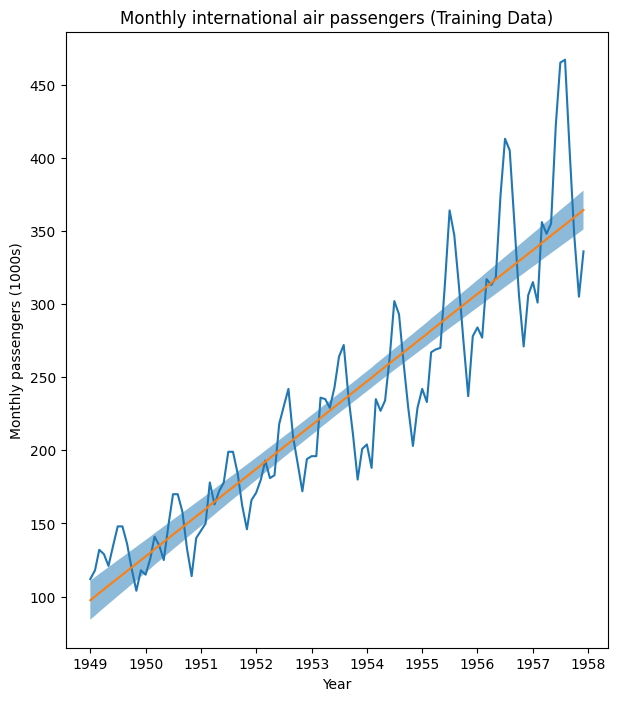

In [18]:
fig, ax = plt.subplots()
plt.plot(trn, label='training data')
plt.plot(y_hat, label='linear regression line')
plt.xlabel('Year')
plt.ylabel('Monthly passengers (1000s)')
plt.title('Monthly international air passengers (Training Data)')
plt.fill_between(y_hat.index, y_ci[:,0],y_ci[:,1],alpha=0.5 , label = '95% conf int')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))


# ARIMA train model

In [19]:
auto_arima_model = auto_arima(trn, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Fri, 16 Feb 2024   AIC                            704.001
Time:                                    01:31:38   BIC                            709.109
Sample:                                01-01-1949   HQIC                           706.065
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

In [25]:
auto_arima_model.order

(1, 1, 0)

In [26]:
auto_arima_model.seasonal_order

(0, 1, 0, 12)

In [34]:
resid= auto_arima_model.resid()
print(resid)

Month
1949-01-01    112.000000
1949-02-01      6.001330
1949-03-01     13.999822
1949-04-01     -2.999625
1949-05-01     -8.000162
                 ...    
1957-08-01     10.964471
1957-09-01    -10.588822
1957-10-01    -11.134531
1957-11-01     -8.928942
1957-12-01     -5.687824
Length: 108, dtype: float64


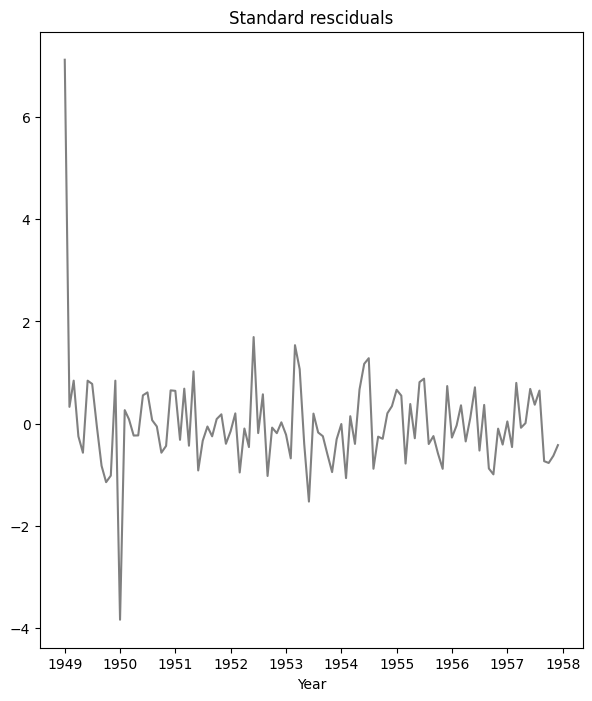

In [35]:
fig, ax = plt.subplots()
plt.plot(trn.index,stats.zscore(resid), color="grey")
plt.xlabel('Year')
plt.title('Standard resciduals')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

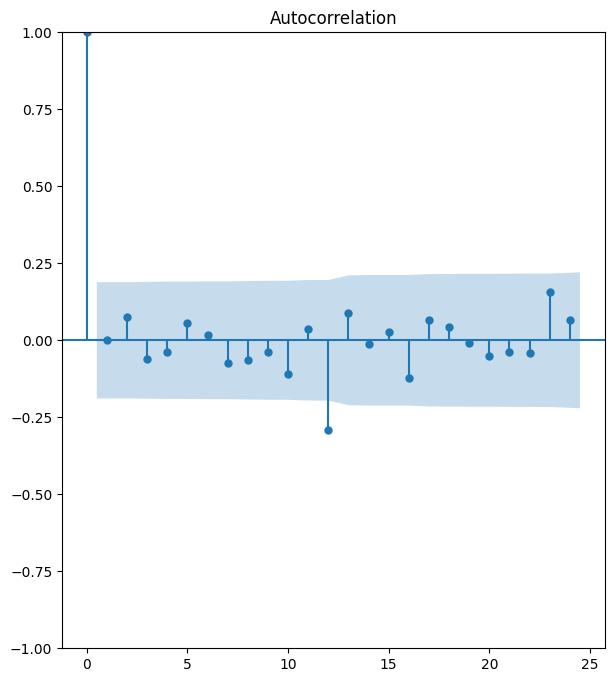

In [47]:
res_acf = plot_acf(resid, lags =24)

In [69]:
res_lb = acorr_ljungbox(resid, lags=24, return_df=False).iloc[:,1]
res_lb

1     0.983222
2     0.722920
3     0.784735
4     0.874231
5     0.901238
6     0.950434
7     0.942999
8     0.947955
9     0.966022
10    0.924728
11    0.948878
12    0.234921
13    0.242589
14    0.304790
15    0.366263
16    0.313146
17    0.344307
18    0.394412
19    0.458833
20    0.500267
21    0.550111
22    0.596634
23    0.447838
24    0.469713
Name: lb_pvalue, dtype: float64

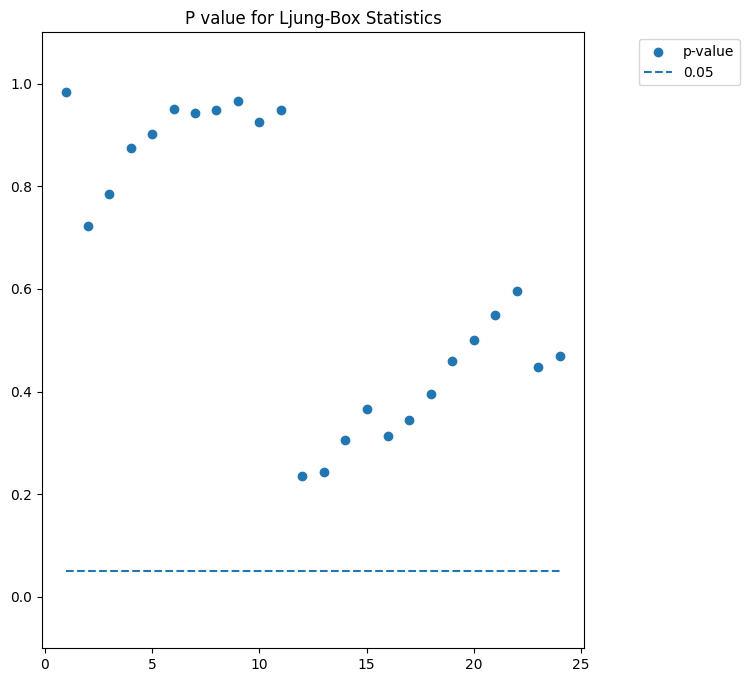

In [70]:
fig, ax = plt.subplots()
plt.title('P value for Ljung-Box Statistics')
plt.scatter(np.arange(1, 1+len(res_lb)), res_lb, label="p-value")
plt.plot(np.arange(1, 1+len(res_lb)),[0.05]*len(res_lb),'--', label='0.05')
plt.ylim(-0.1,1.1)
plt.legend(bbox_to_anchor=(1.3,1))

# TEST MODEL

In [71]:
auto_arima_model.fit(trn)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [78]:
arima_predictions= auto_arima_model.predict(n_periods=36,alpha=0.06, return_conf_int=True)

In [79]:
y_pred = pd.Series(arima_predictions[0], index=tst.index)


In [80]:
y_pred_lb,y_pred_ub= arima_predictions[1][:,0], arima_predictions[1][:,1]

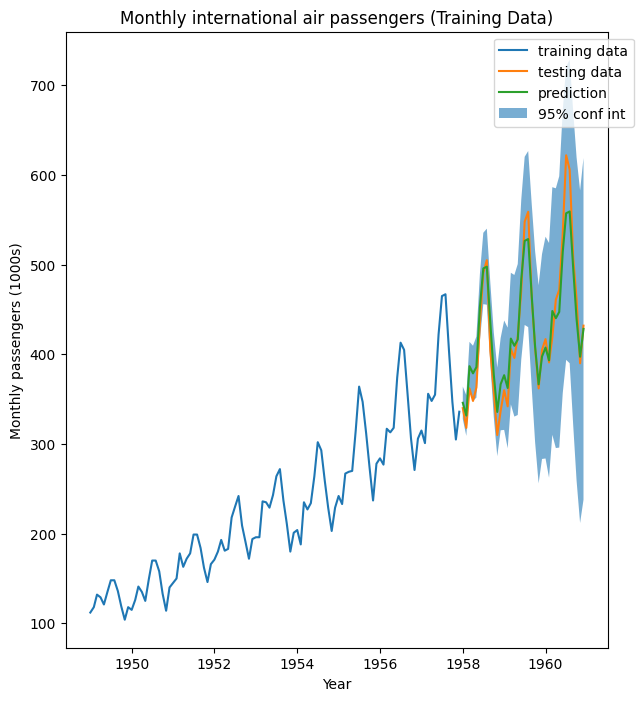

In [81]:
fig, ax= plt.subplots()

plt.plot(trn, label='training data')
plt.plot(tst, label='testing data')
plt.plot(y_pred, label="prediction")
plt.xlabel('Year')
plt.ylabel('Monthly passengers (1000s)')
plt.title('Monthly international air passengers (Training Data)')
plt.fill_between(tst.index, y_pred_lb,y_pred_ub,alpha=0.6 , label = '95% conf int')
plt.legend(bbox_to_anchor=(1.06,1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

In [83]:
test_pred= pd.DataFrame({
    'Actual':  tst.iloc[:,0]. values,
    "point forectast" : y_pred.values,
    'lo_95':y_pred_lb,
    'Hi_95':y_pred_lb
}, index=tst.index)

In [86]:
test_pred.head()

,Actual,point forectast,lo_95,Hi_95
Month,,,,
1958-01-01,340,345.964471,327.851163,327.851163
1958-02-01,318,331.731920,308.993389,308.993389
1958-03-01,362,386.787992,359.657764,359.657764
1958-04-01,348,378.774472,347.991247,347.991247
1958-05-01,363,385.777732,351.705025,351.705025
